In [1]:
import Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import Interpolations as IP
using LaTeXStrings
import JLD2

using FFTW:ifft, fft, fftshift, fftfreq

In [3]:
include("utils.jl")
include("system.jl")
include("constraints.jl")
include("objectives.jl")

QuadraticObjective (generic function with 3 methods)

In [416]:
V = 1e-0
trunc = 4
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=false, bloch_transformation_trunc=2*trunc, include_acc_derivative=true, acc=1e-12)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

8.939026187912745

In [417]:
duration = 2pi * 5 # in units of 1/E_R

T = 4001
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

31.41592653589793

In [418]:
# a = zeros(2, T)
a = vcat(ones(T)', zeros(T)')
acc = collect(times')

1×4001 Matrix{Float64}:
 0.0  0.00785398  0.015708  0.0235619  …  31.3924  31.4002  31.4081  31.4159

In [419]:
reflector = zeros(ComplexF64, dim, dim)
for i=1:dim
    reflector[i,end-i+1] = 1. * 1im
end
reflector = blockdiagonal(reflector, reflector)
reflector = QC.iso_vec_to_iso_operator(QC.operator_to_iso_vec(reflector))

36×36 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -1.0
 ⋮                        ⋮         ⋱   ⋮                             ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0

In [420]:
n_split = 3
splitter = 1.0im * collect(LA.I(dim))
splitter[[-n_split,0,n_split] .+ mid,[-n_split,0,n_split] .+ mid] = [
    1. sqrt(2) -1.
    sqrt(2) 0. sqrt(2)
    -1. sqrt(2) 1.
] / 2. * 1im
splitter = blockdiagonal(splitter, splitter)
splitter = QC.iso_vec_to_iso_operator(QC.operator_to_iso_vec(splitter))

36×36 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 ⋮                        ⋮         ⋱   ⋮                             ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0

In [421]:
psi0 = QC.cavity_state(mid-1, dim)
append!(psi0, zeros(dim))
psi0_iso = QC.ket_to_iso(psi0)

36-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [422]:
psi0_iso = splitter * psi0_iso

36-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [425]:
psi_iso = QC.rollout(psi0_iso, vcat(a, acc)[:,1:div(T,2)], dts[1:div(T,2)], system; integrator=exp)
psi_iso1 = reflector * psi_iso[:,end]
psi_iso = hcat(psi_iso, QC.rollout(psi_iso1, vcat(a, acc)[:,div(T,2):end], dts[div(T,2):end], system; integrator=exp)[:,2:end])

36×4001 Matrix{Float64}:
 0.0  -0.00128013  -0.0019477    …     -0.00037777      -1.30292e-5
 0.0   0.197276     0.378881           -0.684295        -0.706828
 0.0  -0.00135815  -0.00253794         -0.000268437      1.62234e-5
 0.0  -1.98845e-7  -1.56718e-6          3.52432e-5       3.55675e-5
 0.0   1.77132e-9   1.38631e-8          5.96579e-9      -2.80866e-7
 0.0  -1.98845e-7  -1.56718e-6   …      3.52432e-5       3.55675e-5
 0.0  -0.00135815  -0.00253794         -0.000268437      1.62234e-5
 0.0   0.197276     0.378881           -0.684295        -0.706828
 0.0  -0.00128013  -0.0019477          -0.00037777      -1.30292e-5
 0.0   0.0         -2.85935e-6         -9.01271          1.91956
 ⋮                               ⋱                       ⋮
 0.0   0.0         -2.80383e-6          7.12838          9.70206
 0.0   0.0          0.000440538     -3182.44         -3290.53
 0.0   0.0         -2.20154e-6         12.4338          13.7531
 0.0   0.0         -9.92197e-10  …      0.122692    

psi_iso += rand(size(psi_iso)...)

In [426]:
psi_iso

36×4001 Matrix{Float64}:
 0.0  -0.00128013  -0.0019477    …     -0.00037777      -1.30292e-5
 0.0   0.197276     0.378881           -0.684295        -0.706828
 0.0  -0.00135815  -0.00253794         -0.000268437      1.62234e-5
 0.0  -1.98845e-7  -1.56718e-6          3.52432e-5       3.55675e-5
 0.0   1.77132e-9   1.38631e-8          5.96579e-9      -2.80866e-7
 0.0  -1.98845e-7  -1.56718e-6   …      3.52432e-5       3.55675e-5
 0.0  -0.00135815  -0.00253794         -0.000268437      1.62234e-5
 0.0   0.197276     0.378881           -0.684295        -0.706828
 0.0  -0.00128013  -0.0019477          -0.00037777      -1.30292e-5
 0.0   0.0         -2.85935e-6         -9.01271          1.91956
 ⋮                               ⋱                       ⋮
 0.0   0.0         -2.80383e-6          7.12838          9.70206
 0.0   0.0          0.000440538     -3182.44         -3290.53
 0.0   0.0         -2.20154e-6         12.4338          13.7531
 0.0   0.0         -9.92197e-10  …      0.122692    

In [427]:
psi_iso = splitter' * psi_iso

36×4001 Matrix{Float64}:
 0.0   0.000530247   0.0019477    …     0.00105582   -0.000265213
 0.0  -1.38267e-10  -2.1904e-9         -1.26664e-5   -1.25688e-5
 0.0   0.00028126    0.00109826         0.00169708    0.000332215
 0.0  -1.34663e-6   -5.19158e-6         7.37175e-5    7.24561e-5
 1.0   0.96029       0.844315          -0.251936      0.0280584
 0.0  -1.34663e-6   -5.19158e-6   …     7.37175e-5    7.24561e-5
 0.0   0.00028126    0.00109826         0.00169708    0.000332215
 0.0  -1.38267e-10  -2.1904e-9         -1.266e-5     -1.25622e-5
 0.0   0.000530247   0.0019477          0.00105582   -0.000265213
 0.0   0.0          -2.80383e-6         7.12838       9.70206
 ⋮                                ⋱                   ⋮
 0.0   0.0           2.85935e-6         9.01271      -1.91956
 0.0   0.0           0.000694178     -828.55         92.3609
 0.0   0.0           9.83316e-7         8.71212       0.643071
 0.0   0.0          -2.99149e-9   …     0.0827521     0.105324
 0.0   0.0          

In [428]:
splitter'

36×36 adjoint(::Matrix{Float64}) with eltype Float64:
  0.0   0.0   0.0   0.0   0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                             ⋮    ⋱       ⋮                        ⋮
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  

In [429]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)
pops_state = pops[1:dim,:]
psi_state_real = real.(psi[1:dim,:])
pops_derivative = pops[dim+1:end,:]

9×4001 Matrix{Float64}:
 0.0  0.0  1.60373e-11  3.13717e-10  …  132.043         97.8148
 0.0  0.0  6.75956e-7   6.08338e-6        1.08144e7      1.08362e7
 0.0  0.0  5.8137e-12   1.19391e-10     230.5          189.561
 0.0  0.0  9.93349e-18  4.8005e-16        0.0219013      0.0246529
 0.0  0.0  2.05523e-36  1.5475e-34        4.67845e-10    4.69722e-10
 0.0  0.0  9.93349e-18  4.8005e-16   …    0.0219013      0.0246529
 0.0  0.0  5.8137e-12   1.19391e-10     230.5          189.561
 0.0  0.0  6.75956e-7   6.08338e-6        1.08144e7      1.08362e7
 0.0  0.0  1.60373e-11  3.13717e-10     132.043         97.8148

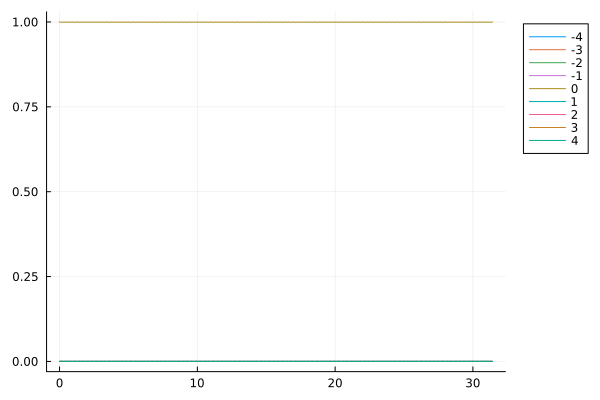

In [430]:
Plots.plot(times, pops_state[:,:]', labels=(-trunc:1:trunc)', legend=:outertopright)#, xlim=(0.0, 2.0))

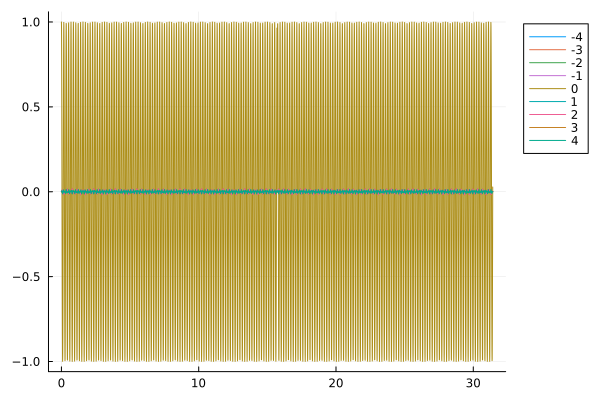

In [431]:
Plots.plot(times, psi_state_real[:,:]', labels=(-trunc:1:trunc)', legend=:outertopright)#, xlim=(0.0, 2.0))

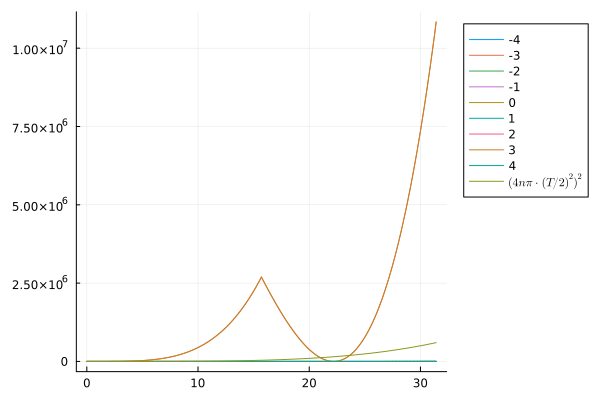

In [432]:
p = Plots.plot(times, pops_derivative[:,:]', labels=(-trunc:1:trunc)', legend=:outertopright)
Plots.plot!(p, times, (1pi*(times/2).^2).^2, label=L"(4n\pi \cdot (T/2)^2)^2")

In [433]:
psi[dim+1:end,:]

9×4001 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  …      9.70206-1.91956im
 0.0+0.0im  0.0+0.0im        -3290.53+92.3609im
 0.0+0.0im  0.0+0.0im         13.7531+0.643071im
 0.0+0.0im  0.0+0.0im        0.116447+0.105324im
 0.0+0.0im  0.0+0.0im     -6.07987e-7-2.16645e-5im
 0.0+0.0im  0.0+0.0im  …    -0.116447-0.105324im
 0.0+0.0im  0.0+0.0im        -13.7531-0.64307im
 0.0+0.0im  0.0+0.0im         3290.53-92.3609im
 0.0+0.0im  0.0+0.0im        -9.70206+1.91956im

In [434]:
psi[dim+1:end,:]

9×4001 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  …      9.70206-1.91956im
 0.0+0.0im  0.0+0.0im        -3290.53+92.3609im
 0.0+0.0im  0.0+0.0im         13.7531+0.643071im
 0.0+0.0im  0.0+0.0im        0.116447+0.105324im
 0.0+0.0im  0.0+0.0im     -6.07987e-7-2.16645e-5im
 0.0+0.0im  0.0+0.0im  …    -0.116447-0.105324im
 0.0+0.0im  0.0+0.0im        -13.7531-0.64307im
 0.0+0.0im  0.0+0.0im         3290.53-92.3609im
 0.0+0.0im  0.0+0.0im        -9.70206+1.91956im

In [435]:
8pi

25.132741228718345

In [437]:
function Fisher(psi, dpsi)
    eps = 0e-10
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F #/ MZFI
end 


Fisher (generic function with 1 method)

In [438]:
fisher = psi_dpsi -> Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])

#448 (generic function with 1 method)

In [439]:
fisher_info = [fisher(psi[:,t]) for t=1:T]

4001-element Vector{Float64}:
  NaN
    0.0
    4.786902644381809e-6
    3.6709818303990036e-5
    0.00011545328604167786
    0.00022742988242234697
    0.000313060559146349
    0.0002928120867952761
    0.00014134692372654356
    5.472733759803983e-7
    ⋮
    2.1047735920650996e7
    5.850309443289653e6
 4900.09418619979
    5.471405209601573e6
    2.114198177029371e7
    4.295501428713146e7
    6.496241548665241e7
    8.103985179611614e7
    8.667844831591025e7

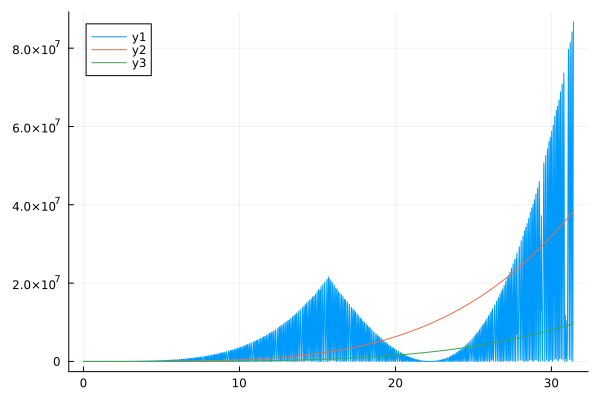

In [440]:
p = Plots.plot(times, fisher_info)
Plots.plot!(p, times, (8pi*(times/2).^2).^2)
Plots.plot!(p, times, (4pi*(times/2).^2).^2)

In [82]:
fisher_info

401-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [115]:
10pi

103.67255756846318

In [79]:
t = T
psi_state = psi[1:dim,t]
psi_derivative = psi[dim+1:end,t]

13-element Vector{ComplexF64}:
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
 -3.659295089164516e-12 + 92.78628296579787im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
  3.652189661806915e-12 - 92.78628296579781im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im

bloch_states = hcat([get_bloch_state(system; lvl=i) for i=0:dim-1]...)

psi

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

Plots.plot(times, bloch_pops[:,:]', labels=(0:8)', legend=:outertopright)#, xlim=(0.0, 2.0))

pops[:, end]

In [ ]:
comps = (
    psi_iso = psi_iso,
    a = a,
    da = da,
    dda = dda,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    a = [1.; 0.],
    #da = zeros(2)
)
final = (;
    a = [1.; 0.],
    #da = zeros(2)
)
goal = (;)
bounds = (
    a = a_bound,
    dda = dda_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:dda),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

import JLD2

JLD2.save("./interferometer/mirror_victor2_opt2.jld2", Z_guess)

Z_guess = NT.copy(Z_save)

NT.update_bounds!(Z_guess, :dda, [-5000. -5000.; 5000. 5000.])

In [ ]:
#state_goal = get_bloch_state(system; lvl=7)
state_goal = QC.cavity_state(3, dim)

In [ ]:
pops_goal = abs2.(state_goal)

In [ ]:
dim = system.params[:dim]

In [ ]:
R = collect(LA.I(dim))
R[8,8] = R[9,9] = 0.
R = QC.QuantumSystems.iso(R)

In [ ]:
# J = NameComponentPathObjective(
#     :psi_iso,
#     1:dim,
#     [1:T...],
#     [time -> pop for pop in pops_goal],
#     [x -> abs2.(x) for _=1:dim],
#     collect(1:T)' .* fill(1., dim, T);
#     is_iso=true
# )

# J = NameComponentPathObjective(
#     :psi_iso,
#     1:2*dim,
#     [1:T...],
#     [time -> s for s in QC.ket_to_iso(state_goal)],
#     [x -> x for _=1:2*dim],
#     collect(1:T)' .* fill(1., 2*dim, T);
#     is_iso=false
# )

# J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, ones(1)*1e-1; is_iso=false)

# J = NameComponentObjective(:psi_iso, [mid-1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid+1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid], steer_to_pops([0.0]), 1.0; is_iso=true)

#J += NameComponentQuadraticRegularizer(:psi_iso, [mid-2, mid+2], Z_guess, ones(2)*1e-3; is_iso=true)
# J += NameComponentQuadraticRegularizer(:psi_iso, [mid-1, mid+1], Z_guess, ones(2)*1e-3; is_iso=true)

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J = QuadraticObjective(:psi_iso, R, 100.0)
# J += NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-8/T)

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    QC.DerivativeIntegrator(
        :a,
        :da,
        :dts,
        Z_guess
    ),
    QC.DerivativeIntegrator(
        :da,
        :dda,
        :dts,
        Z_guess
    )
]

In [ ]:
constraints = [
    OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
Z.psi_iso

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
psi[:,end]

In [ ]:
state_goal

In [ ]:
1 - Z.psi_iso[:,end]' * R * Z.psi_iso[:,end]

In [ ]:
x = QC.iso_to_ket(Z.psi_iso[:,end])

In [ ]:
x / exp(1im*angle(x[8]))

In [ ]:
pops_goal

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
#p = Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright, size=(500, 300))
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times, pops[end,:])

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

p = Plots.plot(times, bloch_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel=L"population of Bloch state $|B\rangle$"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.da')

In [ ]:
Plots.plot(times, Z.dda')

In [ ]:
phi = angle.(Z.a[1,:] + 1im * Z.a[2,:]);
phi_mod_clean!(phi)

In [ ]:
times_f1 = times[div(2*T,3):end]
sin_f1 = pi/2*sin.(29.6*(times_f1 .- 0.27)) .- pi/2
times_f2 = times[1:div(2*T,3)]
sin_f2 = pi*sin.(11.5*(times_f2));

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times_f1, sin_f1, linecolor=:red, alpha=0.2, label=L"\omega=29.6")
# Plots.plot!(p, times_f2, sin_f2, linecolor=:green, alpha=0.2, label=L"\omega=11.5")
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times[150:250], Z.a[:,150:250]')

In [ ]:
Plots.plot(times[150:250], Z.a[1,150:250].^2 + Z.a[2,150:250].^2)

In [ ]:
Plots.plot(times[150:250], phi[150:250])

In [ ]:
maximum(phi)

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
import JLD2

JLD2.save("interferometer/split_bloch78.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
slice = 1:T #div(2*T,3):T

In [ ]:
freqs = collect(0:0.1:80)
phi_ft = fourier_time_freq(phi[slice], times[slice], freqs/2pi);

In [ ]:
p = Plots.plot(freqs, abs2.(phi_ft), size=(500, 300), label=nothing)
Plots.xaxis!(p, 
    xlabel=L"$\omega$ $[\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Fourier amplitude"
)
Plots.title!(p, "Shaking protocol spectrum")

# mirror

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
for i=0:15
    println("$i\t$(system.params[:bloch_energies][i+1])")
end

In [ ]:
Plots.bar(real.(system.params[:bloch_states][:,[7,8].+1]))

In [ ]:
system.H_drives_real[1]

In [ ]:
duration = 2pi * 0.5 # in units of 1/E_R

T = 401
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
a_bound = fill(1., 2)
dda_bound = fill(2000., 2)


a = vcat(ones(T)', zeros(T)') 
#a = vcat(cos.(2pi * times/duration)', sin.(2pi * times/duration)')

# a = vcat(cos.(2. *sin.(11.5 *times))', sin.(2. *sin.(11.5 *times))') + vcat(cos.(2. *sin.(29.6 *times))', sin.(2. *sin.(29.6 *times))')
# a /= 2.

#a = 1. * vcat(cos.(sin.(29.6 *times))', sin.(sin.(29.6 *times))')

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
Z1 = NT.load_traj("./interferometer/bloch_7_to_3.jld2")
Z2 = NT.load_traj("./interferometer/mirror_victor2.jld2")

In [ ]:
Z1.dts, Z2.dts

In [ ]:
a, dts = get_interferometer(Z1, Z2, [])
times = cumsum(dts) - dts
T = length(times)

In [ ]:
Z = NT.load_traj("./interferometer/mirror_bloch7_bitshorter.jld2")

In [ ]:
Z = NT.load_traj("./interferometer/mirror_victor2.jld2")

In [ ]:
a, dts = Z.a, vec(Z.dts)
times = cumsum(dts) - dts
duration = times[end]
T = length(times)

In [ ]:
T_new = 600
dt_new = duration[end]/(T_new-1)
dts_new = fill(dt_new, T_new);

In [ ]:
a = interpolate_controls(a, dts, dts_new)
times = cumsum(dts_new) - dts_new;

In [ ]:
a = a[:,1:500]
times = times[1:500]

In [ ]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dts = fill(dt, T)
dt_bound = (dt, dt)
T

In [ ]:
a_bound = fill(1., 2)
dda_bound = fill(2000., 2)

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
times

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, da')

In [ ]:
Plots.plot(times, dda')

In [ ]:
phi = angle.(a[1,:] + 1im*a[2,:])
phi_mod_clean!(phi)

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
#psi0 = get_bloch_state(system; lvl=3)
psi0 = QC.cavity_state(3, dim)
v0 = psi0 + QC.cavity_state(4, dim)
normalize!(v0)
w0 = psi0 - QC.cavity_state(4, dim)
normalize!(w0)

In [ ]:
system.params[:bloch_energies]

In [ ]:
Plots.bar(0:dim-1, hcat(real.(psi0), real.(v0), real.(w0)))

In [ ]:
psi0_iso = QC.ket_to_iso(psi0)
v0_iso = QC.ket_to_iso(v0)
w0_iso = QC.ket_to_iso(w0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)
v_iso = QC.rollout(v0_iso, a, dts, system; integrator=exp)

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
psi_pops = abs2.(psi)
v = hcat([QC.iso_to_ket(v_iso[:,t]) for t=1:T]...)
v_pops = abs2.(v)

In [ ]:
p = Plots.plot(times, psi_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle \rightarrow |3\rangle$ (guess)")

In [ ]:
p = Plots.plot(times, v_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle + |4\rangle \rightarrow |3\rangle - |4\rangle$")

In [ ]:
comps = (
    psi_iso = psi_iso,
    v_iso = v_iso,
    a = a,
    da = da,
    dda = dda,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    v_iso = v0_iso,
    a = [1.; 0.],
    #da = zeros(2)
)
final = (;
    a = [1.; 0.],
    #da = zeros(2)
)
goal = (;)
bounds = (
    a = a_bound,
    dda = dda_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:dda),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

In [ ]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=psi0_iso, loss=:InfidelityLoss, Q=100.0)
J += QC.QuantumObjective(name=:v_iso, goals=w0_iso, loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-8/T)

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :v_iso,
        :a,
        :dts;
        order=4
    ),
    QC.DerivativeIntegrator(
        :a,
        :da,
        :dts,
        Z_guess
    ),
    QC.DerivativeIntegrator(
        :da,
        :dda,
        :dts,
        Z_guess
    )
]

In [ ]:
constraints = [
    OmegaAbsConstraint(1.0, Z_guess),
    #LinearSincConvolutionConstraint3(:a, :dts, Z_guess, 50.)
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=100,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

v_iso_rollout = QC.rollout(v0_iso, Z.a, Z.dts, system; integrator=exp)
v = hcat([QC.iso_to_ket(v_iso_rollout[:,t]) for t=1:T]...)
v_pops = abs2.(v)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
psi[:,end]

In [ ]:
abs2.(psi[:,end]' * psi0)

In [ ]:
abs2.(v[:,end]' * w0)

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle \rightarrow |3\rangle$")

In [ ]:
p = Plots.plot(times, v_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle + |4\rangle \rightarrow |3\rangle - |4\rangle$")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.da')

In [ ]:
Plots.plot(times, Z.dda')

In [ ]:
phi = angle.(Z.a[1,:] + 1im * Z.a[2,:]);
phi_mod_clean!(phi)

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
import JLD2

In [ ]:
JLD2.save("interferometer/mirror_victor2_opt.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

In [ ]:
sinc_con.kernel

In [ ]:
a2 = (sinc_con.kernel * Z.a[1:2,1:end-1]')'

In [ ]:
phi2 = angle.(a2[1,:] + 1im*a2[2,:])

In [ ]:
phi2 = sinc_con.kernel * phi[1:T-1]

In [ ]:
Plots.plot(a2')

In [ ]:
Plots.plot(abs2.(a2'))

In [ ]:
freqs = collect(0:0.1:50)
#phi_ft = fourier_time_freq(Z.a[1,:], times, freqs/(2pi));
phi_ft = fourier_time_freq(phi2, times[1:end-1], freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

# interferometer

In [ ]:
Z_split = NT.load_traj("interferometer/split_victor_opt2.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor2_opt.jld2")

In [ ]:
time_flight = 2pi * 2.0
dt_flight = Z_split.dts[1]
T_flight = Int(div(time_flight,dt_flight)) + 1

In [ ]:
a, dts = get_interferometer(Z_split, Z_mirror, fill(dt_flight, T_flight))
#a, dts = get_interferometer(Z_split, Z_mirror, [])
times = cumsum(dts) - dts
T = length(times)

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
psi0 = QC.cavity_state(0, dim)
psi0_iso = QC.ket_to_iso(psi0)

In [ ]:
lbls = reshape(0:dim-1, 1, dim)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system);

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

In [ ]:
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(700, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Interferometer ($8 k_L$ splitting)")

In [ ]:
Plots.plot(times, a', size=(1100, 400), label=lbls, legend=:outertopright)

In [ ]:
phi = angle.(a[1,:] + im*a[2,:])
phi_mod_clean!(phi);

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(700, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Interferometer ($16k_L$ splitting)")

In [ ]:
system_acc = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc, include_acc_derivative=true)
a_acc = vcat(a, times')

In [ ]:
psi0_acc = vcat(psi0, zeros(length(psi0)))
psi0_acc_iso = QC.ket_to_iso(psi0_acc)

In [ ]:
psi_acc_iso = QC.rollout(psi0_acc_iso, a_acc, dts, system_acc)

In [ ]:
# psi_acc = hcat([QC.iso_to_ket(psi_acc_iso[:,t])[1:dim] for t=1:T]...)
# pops_acc = hcat([abs2.(QC.iso_to_ket(psi_acc_iso[:,t]))[1:dim] for t=1:T]...)

psi_acc = hcat([QC.iso_to_ket(psi_acc_iso[:,t]) for t=1:T]...)
pops_acc = abs2.(psi_acc)

In [ ]:
p1 = Plots.plot(times, pops_acc[1:dim,:]', label=lbls, legend=:outertopright)
p2 = Plots.plot(times, pops_acc[dim+1:end,:]', label=lbls, legend=:outertopright)
Plots.plot(p1, p2, size=(1100, 800), layout=Plots.@layout [a; b])

In [ ]:
bloch_states = system.params[:bloch_states]
d = size(bloch_states,1)
bloch_states = bloch_states[(1:dim) .+ div(d,4) .+ 1, 1:dim]

In [ ]:
B = blockdiagonal(bloch_states, bloch_states)

In [ ]:
Plots.bar(real.(bloch_states[:,8]))

In [ ]:
bloch_states * psi_acc[1:dim,:]

In [ ]:
p_acc = B * psi_acc
p_pops_acc = abs2.(p_acc)

In [ ]:
p1 = Plots.plot(times, p_pops_acc[1:dim,:]', label=(-div(dim,2):div(dim,2))', legend=:outertopright)
p2 = Plots.plot(times, p_pops_acc[dim+1:end,:]', label=(-div(dim,2):div(dim,2))', legend=:outertopright)
Plots.plot(p1, p2, size=(1100, 800), layout=Plots.@layout [a; b])

In [ ]:
p_pops_acc[dim+1:end,end]

In [ ]:
MZFI = (8pi*(times[end]/2)^2)^2

In [ ]:
function Fisher(psi, dpsi)
    eps = 0.0
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F / MZFI
end 


In [ ]:
#fisher = psi_dpsi -> Fisher(QC.iso_to_ket(psi_dpsi)[1:dim], QC.iso_to_ket(psi_dpsi)[dim+1:2*dim])
fisher = psi_dpsi -> Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])

In [ ]:
fisher_info = [fisher(p_acc[:,t]) for t=1:T]

In [ ]:
p = Plots.plot(times, fisher_info, size=(700, 300), label=nothing)
Plots.xlabel!(p, L"time $t \, [1/\omega_R]$")
Plots.ylabel!(p, "F [MZFI]")
Plots.title!(p, "Fisher information")

In [ ]:
function fisher_for_flight(dts_flight):
    a, dts = get_interferometer(Z_split, Z_mirror, fill(dt_flight, T_flight))
    times = cumsum(dts) - dts
    T = length(times)
    system_acc = ShakenLatticeSystem1D(V, p_max; include_acc_derivative=true)
    a_acc = vcat(a, times')
    psi0_acc = vcat(psi0, zeros(length(psi0)))
    psi0_acc_iso = QC.ket_to_iso(psi0_acc)
    psi_acc_iso = QC.rollout(psi0_acc_iso, a_acc, dts, system_acc)

In [ ]:
dim = system.params[:dim]
# J = NameComponentPathObjective(
#     :psi_iso,
#     1:dim,
#     [1:T...],
#     [time -> pop for pop in pops_goal],
#     [x -> abs2.(x) for _=1:dim],
#     collect(1:T)' .* fill(1., dim, T);
#     is_iso=true
# )

# J = NameComponentPathObjective(
#     :psi_iso,
#     1:2*dim,
#     [1:T...],
#     [time -> s for s in QC.ket_to_iso(state_goal)],
#     [x -> x for _=1:2*dim],
#     collect(1:T)' .* fill(1., 2*dim, T);
#     is_iso=false
# )

# J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, ones(1)*1e-1; is_iso=false)

# J = NameComponentObjective(:psi_iso, [mid-1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid+1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid], steer_to_pops([0.0]), 1.0; is_iso=true)

#J += NameComponentQuadraticRegularizer(:psi_iso, [mid-2, mid+2], Z_guess, ones(2)*1e-3; is_iso=true)
# J += NameComponentQuadraticRegularizer(:psi_iso, [mid-1, mid+1], Z_guess, ones(2)*1e-3; is_iso=true)

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-7/T)

In [ ]:
dim = 15
mid = div(dim + 1, 2)

In [ ]:
ps = collect(-mid+1:mid-1)

In [ ]:
psi0 = zeros(dim)
psi0[mid] = 0.8
psi0[mid-1] = -0.6
psi0[mid+1] = -0.6

In [ ]:
s = 3
psi0 = exp.(-ps.^2/s^2)
psi0 ./ LA.norm(psi0)

In [ ]:
Plots.plot(ps, psi0)

In [ ]:
psi0_ft = ifft(psi0)

In [ ]:
x_vals = fftshift(fftfreq(dim))

In [ ]:
abs2.(psi0_ft)

In [ ]:
x_vals

In [ ]:
psi0_ft

In [ ]:
fig = Plots.plot(x_vals, abs2.(fftshift(psi0_ft)), ylimit=(0,0.001))

In [ ]:
FFTW.fftshift(FFTW.fftfreq(10))

In [ ]:
function p_to_x(psi_p, xs)
    dim = length(psi_p)
    p_max = div(dim - 1, 2)
    ps = collect(-p_max:p_max) 
    ft_mat = exp.(1im*xs*ps')
    return ft_mat * psi_p / sqrt.(2pi)
end

In [ ]:
function x_to_p(psi_x, xs, p_max)
    ps = collect(-p_max:p_max) 
    ft_mat = exp.(-1im*ps*xs')
    return ft_mat * psi_x .* (xs[2] - xs[1]) / sqrt.(2pi)
end

In [ ]:
xs = LinRange(-10, 10, 1000)

In [ ]:
psi0_ft2 = p_to_x(psi0, xs)

In [ ]:
Plots.plot(xs, hcat(abs2.(psi0_ft2), cos.(xs)))

In [ ]:
sx = 1
psi_x = exp.(-(xs .- pi).^2 / sx^2)
psi_x ./= LA.norm(psi_x) * sqrt.(xs[2]-xs[1])

In [ ]:
sum(abs2.(psi_x)) * (xs[2]-xs[1])

In [ ]:
Plots.plot(xs, hcat(abs2.(psi_x), -cos.(xs)))


In [ ]:
psi_p = x_to_p(psi_x, xs, 20)

In [ ]:
Plots.plot(-20:20, abs2.(psi_p))

In [ ]:
psi_p_ft = fft(psi_x)

In [ ]:
Plots.plot(fftshift(fftfreq(1000))*500/2/pi, fftshift(abs2.(psi_p_ft)), xlimit=(-10, 10))